In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4

In [2]:
# !pip install nltk

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette= 'summer')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
dataset = load_dataset('IlyaGusev/gazeta', revision='v1.0')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for IlyaGusev/gazeta contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/IlyaGusev/gazeta.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

In [7]:
sentences = []

for text in tqdm(dataset['validation']['text']):
  sentences.extend(
      [x.lower() for x in sent_tokenize(text, language='russian') if len(x) < 256]
  )

  0%|          | 0/5265 [00:00<?, ?it/s]

In [8]:
len(sentences)

191894

In [9]:
chars = Counter()
for sentence in tqdm(sentences):
  for char in sentence:
    chars[char] += 1

  0%|          | 0/191894 [00:00<?, ?it/s]

In [10]:
len(chars.items())

153

In [11]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 1000

for char, cnt, in tqdm(chars.items()):
  if cnt > counter_threshold:
    vocab.add(char)

  0%|          | 0/153 [00:00<?, ?it/s]

In [12]:
len(vocab)

86

In [13]:
char2ind = {char: i for i, char in enumerate(vocab)}
ind2char = {i: char for char, i in char2ind.items()}

In [14]:
class CharDataset:
  def __init__(self, sentences):
    self.data = sentences
    self.unk_id = char2ind['<unk>']
    self.bos_id = char2ind['<bos>']
    self.eos_id = char2ind['<eos>']
    self.pad_id = char2ind['<pad>']

  def __getitem__(self, idx: int) -> List[int]:
    tokenized_sentence = [self.bos_id]
    tokenized_sentence += [char2ind.get(char, self.unk_id) for char in self.data[idx]]
    tokenized_sentence += [self.eos_id]
    return tokenized_sentence

  def __len__(self) -> int:
    return len(self.data)


In [15]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=char2ind['<pad>']) -> torch.Tensor:
    max_seq_len = max(len(sent) for sent in input_batch)
    new_batch = []
    for sequence in input_batch:
      for _ in range(max_seq_len - len(sequence)):
        sequence.append(pad_id)
      new_batch.append(sequence)
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:, :-1],
        'target_ids': sequences[:, 1:]
    }
    return new_batch

In [16]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)

train_dataset = CharDataset(train_sentences)
eval_dataset = CharDataset(eval_sentences)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=256)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=256)


In [17]:
class CharLM(nn.Module):
  def __init__(self, hidden_dim: int, vocab_size: int):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, hidden_dim)
    self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
    self.Linear = nn.Linear(hidden_dim, hidden_dim)
    self.projection = nn.Linear(hidden_dim, vocab_size)

    self.non_lin = nn.Tanh()
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, input_batch) -> torch.Tensor:
    embeddings = self.embedding(input_batch)
    output, _ = self.rnn(embeddings)
    output = self.dropout(self.Linear(self.non_lin(output)))
    projection = self.projection(self.non_lin(output))

    return projection



In [25]:
def evaluate(model, criterion) -> float:
  model.eval()
  perplexity = []
  with torch.no_grad():
    for batch in eval_dataloader:
      logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
      loss = criterion(
          logits,
          batch['target_ids'].flatten()
      )
      perplexity.append(torch.exp(loss).item())

  perplexity = sum(perplexity) / len(perplexity)
  return perplexity

In [26]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=char2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [27]:
num_epoch = 25
losses = []
perplexities = []

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        loss = criterion(
            logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    losses.append(sum(epoch_losses) / len(epoch_losses))
    perplexities.append(evaluate(model, criterion))

Training epoch 0::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/600 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/600 [00:00<?, ?it/s]

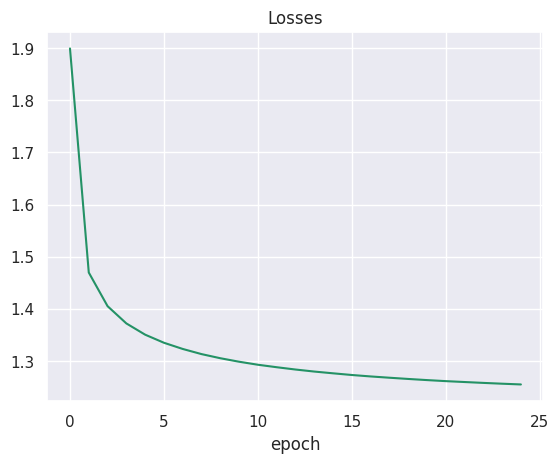

In [29]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel('epoch')
plt.show()

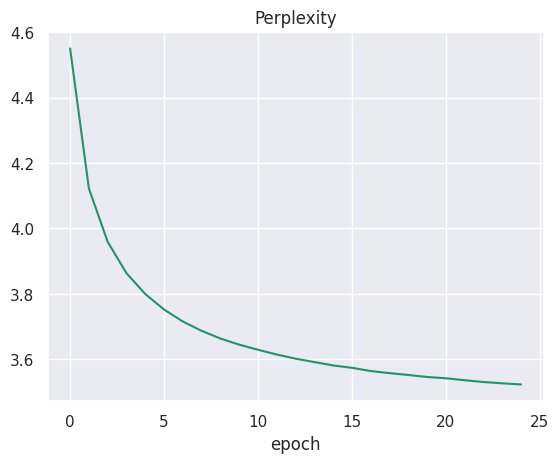

In [30]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [31]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [char2ind['<bos>']] + [
        char2ind.get(char, char2ind['<unk>']) for char in starting_seq]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == char2ind['<eos>']:
                break

    words = ''.join([ind2char[idx.item()] for idx in input_ids])

    return words

In [35]:
generate_sequence(model, starting_seq='мальчик пробежал мимо')

'<bos>мальчик пробежал мимо по статье 105 ук рф «убийство» в своем инстаграме поставки составляет 100 тыс. рублей.<eos>'